# Different Python implementations to work with Riemannian neural networks

In this example, we are going to do a basic tutorial on how to use different toolboxes designed for quickly setting up manifolds optimization

## Import necesary libraries

In [20]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import warnings

warnings.filterwarnings('ignore')

## Data creation

To illustrate the example we are going to suppose we have a set of data that live in an sphere, $S^2$, with two different classes. To make a complex problem, the classes are splited making two intertwined spirals, we add noise to the data to make it more real

In [21]:
def generate_sphere_data(n_samples: int = 300, noise: float = 0.15) -> tuple:
    """
    Generates data with a spiral pattern in the sphere.
    Args:
    - n_samples (int): number of samples to generate
    - noise (float): how much noise to add
    Returns:
    tuple with X and Y (label) data
    """
    # Add seed for reproductivity
    np.random.seed(42)
    
    # Class 0: Spiral in clock-wise direction
    t1 = np.linspace(0, 4*np.pi, n_samples//2)
    theta1 = np.pi/4 + (np.pi/3) * np.sin(t1/2)
    phi1 = t1 
    
    # Class 1: Spiral in anti-clock-wise direction
    t2 = np.linspace(0, 4*np.pi, n_samples//2)
    theta2 = 3*np.pi/4 - (np.pi/3) * np.sin(t2/2)
    phi2 = -t2 + np.pi
    
    theta = np.concatenate([theta1, theta2])
    phi = np.concatenate([phi1, phi2])
    
    # Convert to cartesian direction
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    # Add noise
    X = np.stack([x, y, z], axis=1)
    X += np.random.randn(*X.shape) * noise
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    # Complicated labels in the frontier
    y = np.concatenate([np.zeros(n_samples//2), np.ones(n_samples//2)])
    
    # Change some labels in the boundary to avoid linear separation
    boundary_noise = 20
    boundary_indices = np.random.choice(n_samples, boundary_noise, replace=False)
    y[boundary_indices] = 1 - y[boundary_indices]
    
    return X.astype(np.float32), y.astype(np.int64)

## Clasic model

Now, we are going to design all the architectures to compare them. 

We are going to start with the basic, clasic, model. We are also going to design a function to train it with the usual, without geomtry, protocol

In [22]:
class ClassicalNN(nn.Module):
    """Clasic neural network with linear layer 
    and ReLUs with a dropout"""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)


In [23]:
def train_classical(X: torch.Tensor, y: torch.Tensor, epochs: int = 100) -> tuple:
    """
    Trains classical model
    Args:
    - X (torch.Tensor): points to classify
    - y (torch.Tensor): labels
    - epochs (int): number of epochs to train for
    Returns:
    - tuple with model and losses across the epochs
    """
    model = ClassicalNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return model, losses


## Pymanopt

Pymanopt is a helpful tool to handle a variety of geometry constraints. It offers a wide variety of manifolds, optimization algorithms and tools to efficiently solve nonlinear problems involving manifold constraints. A Riemannian optimization in Pymanopt is designed as a problem including manifold structures that the search space is confined to. However, one drawback for this toolbox is that it works with numpy data, so it has to be manually created when working with torch. In general, pymanopt is limited to shallow learning optimizations and are not applicable to deep learning optimizations.
It has:
- **Typical manifolds**: it has typical manifolds you can work upon. Some examples include:
    - **RiemannianSubmanifold**: the base class upon all other manifolds are built
    - **Euclidean**: euclidean space
    - **Sphere**: $S^n$
    - **Stiefel**
    - **Grasssman**
    - **Symmetric Positive Definite Matrices**
    - **Positive Semidefinite Matrices**
    - **Hyperbolic Space**
- **Functions**: Cost functions, gradients and Hessian-vector products (hvps). It has pymanopt.function.pytorch(manifold), but, from our experience, it does not work well
- **Optimization algorithms**: optimizers in Riemann manifolds

    Each of them have various functions you can explore in the oficial documentation: https://pymanopt.org/docs/latest/manifolds.html

First, we need to make sure we have Pymanopt installed correcly

In [24]:
try:
    import numpy as np
    import pymanopt
    from pymanopt.manifolds import Sphere
    from pymanopt import Problem
    from pymanopt.optimizers import ConjugateGradient
    import pymanopt.function

    PYMANOPT_AVAILABLE = True

except ImportError:
    PYMANOPT_AVAILABLE = False
    print("Pymanopt not available. Install using: pip install pymanopt")

In [25]:
def train_pymanopt(X: np.ndarray, y: np.ndarray, epochs: int = 100) -> tuple:
    """ 
    Train a model on the 3-dimensional sphere.
    Args:
    - X (np.ndarray): Input data of shape (n_samples, 3)
    - y (np.ndarray): Binary labels (0 or 1) of shape (n_samples,)
    - epochs (int) Maximum number of optimization steps to track
    Returns:
    w_opt (np.ndarray): Final point on the shere after optimization
    losses (list): list of loss values
    """

    # Define the manifold where the data lives
    manifold = Sphere(3)
    
    # Convert everything to NumPy for Pymanopt's NumPy backend
    X_np = X.astype(np.float64)
    y_np = y.astype(np.float64).reshape(-1, 1)
    
    losses = []
    
    # Define the cost function in the manifold
    # The wrapper is essential
    @pymanopt.function.numpy(manifold)
    def cost(w: np.array) -> np.ndarray:
        """
        Define the cost function in the manifold
        Args:
        - w (np.ndarray)
        Returns:
        loss value
        """
        # Convert everything to numpy to avoid problems
        w_reshaped = w.reshape(-1, 1)
        scores = np.dot(X_np, w_reshaped)

        # Sigmoid activation in Numpy
        pred = 1.0 / (1.0 + np.exp(-scores))

        # Compute mean square error
        loss = np.mean((pred - y_np) ** 2)
        
        # Store loss evolution
        losses.append(float(loss))
        
        return loss
    
    # Define the Explicit Euclidean gradient
    #    (Pymanopt will automatically convert it to the
    #     Riemannian gradient on the manifold.)
    # The wrapper is essential
    @pymanopt.function.numpy(manifold)
    def euclidean_gradient(w):
        """
        Compute the euclidean gradient of the loss with respect
        to w in R^3, before projecting it onto the tangent space
        """
        # Manual euclidean gradient
        w_reshaped = w.reshape(-1, 1)
        scores = np.dot(X_np, w_reshaped)
        pred = 1.0 / (1.0 + np.exp(-scores))
        error = pred - y_np
        # d/dw MSE(pred, y) where pred = sigmoid(Xw)

        grad = 2.0 * np.dot(X_np.T, error * pred * (1 - pred)) / len(y_np)
        return grad.flatten()
    
    # Create the pymanopt problem to optimize
    problem = Problem(manifold=manifold, cost=cost, euclidean_gradient=euclidean_gradient)
    
    # Choose a Pymanopt optimizer
    optimizer = ConjugateGradient(max_iterations=min(epochs, 50))
    
    # Initialize the weight in the sphere
    np.random.seed(42)
    w_init = manifold.random_point()

    # One iteration of the optimization
    result = optimizer.run(problem, initial_point=w_init)
    
    # Repeat for the reaming epochs
    while len(losses) < epochs:
        losses.append(losses[-1] if losses else 0.5)
    
    return result.point, losses[:epochs]


## Geopt

Geopt is a toolbox that extends from torch.nn.Module.parameters. Extended. Geoopt supports tensors and parameters on the manifold. Moreover, Geoopt provides Riemannian optimizers, for instance, RiemannianSGD and RiemannianAdam are available and inherited from torch.optim.SGD and torch.optim.Adam, respectively.

To use geopt, we have to define a "normal" pytorch architecture, defining that some nn.Parameters may live in a certain manifold. The training is very similar to the one in the "classical" network, with the difference that we are going to use an specific optimizer given that the weights live in a manifold.

The problem with this toolbox is that there are very fwe manifolds available (Euclidean, sphere, Stiefel and Poincaré ball)

First, we need to check we have it installed correctly

In [26]:
try:
    import geoopt
    GEOOPT_AVAILABLE = True
except ImportError:
    GEOOPT_AVAILABLE = False
    print("Geoopt no disponible. Instalar con: pip install geoopt")

In [27]:
class GeooptNN(nn.Module):
    """
    Network where the weights (w) live on the sphere manifold
    """
    def __init__(self):
        super().__init__()
        # How to define weights in a certain manifold
        self.weight = geoopt.ManifoldParameter(
            torch.randn(3, 32),
            manifold=geoopt.manifolds.Sphere()
        )
        # Classical layers
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        return self.fc3(x)


In [28]:
def train_geoopt(X: torch.Tensor, y: torch.Tensor, epochs: int = 100):
    """
    Trains with geoopt
    Args:
    - X (torch.Tensor): points to classify
    - y (torch.Tensor): labels
    - epochs (int): number of epochs to train for
    Returns:
    - tuple with model and losses across the epochs
    """

    model = GeooptNN()
    criterion = nn.CrossEntropyLoss()
    
    # Define a new optimizer
    optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=0.005)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return model, losses


## Mctorch

Mctorch is a toolbox that has been created to fill the gaps that Pymanopt has. It builds upon Pytorch and it implements a generael solution for deep learning optimizations in the manifold. As geoopt, it only needs to define modules and optimizers. The problem is that has a higher infrastructure cost than geoopt, it only has implement Stiefel and the SPD manifolds, and, for today, it does not offer support

In [29]:
try:
    import mctorch.nn as mnn
    import mctorch.optim as moptim
    MCTORCH_AVAILABLE = True
except (ImportError, AttributeError) as e:
    MCTORCH_AVAILABLE = False
    print(f"McTorch no disponible o incompatible: {e}")
    print("Instalar con: pip install git+https://github.com/mctorch/mctorch.git")

In [30]:
class McTorchNN(nn.Module):
    """
    Network with Mctorch
    """
    def __init__(self):
        super().__init__()
        # Define the manifold class.
        # Note: Stiefel requires height >= width, so we use 32x3
        # and then transpose in the forward 
        manifold_class = mnn.Stiefel(64, 3)
        self.weight = mnn.Parameter(
                data=torch.randn(64, 3),
                manifold=manifold_class
            )
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        self.bn1 = nn.BatchNorm1d(64)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Same as in classical, adding the transpose in the weights
        x = torch.matmul(x, self.weight.t())  # (batch, 3) x (3, 64)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        return self.fc4(x)


In [31]:
def train_mctorch(X: torch.Tensor, y: torch.Tensor, epochs: int = 100) -> tuple:
    """
    Trains with Mctorch
    Args:
    - X (torch.Tensor): points to classify
    - y (torch.Tensor): labels
    - epochs (int): number of epochs to train for
    Returns:
    - tuple with model and losses across the epochs
    """
        
    model = McTorchNN()
    criterion = nn.CrossEntropyLoss() 
    
    # Use the special optimizer
    optimizer = moptim.rAdagrad(model.parameters(), lr=0.01)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return model, losses


## Geomstats

Geomstats is a toolbox that has two modules: geomtry (with metrics) and learning (with statistics and learning algorithms inherited from Scikit-Learn). It has many manifolds available (Euclidean, Minkovsky, hyperbolic, Stiefel, GRassman, SPD and Landmarks amongst others) and it is easy to use. The problem is that is does not integrate well with Pytorch and the syntax is different.

In [32]:
try:
    import geomstats.backend as gs
    from geomstats.geometry.hypersphere import Hypersphere
    from geomstats.learning.frechet_mean import FrechetMean
    GEOMSTATS_AVAILABLE = True
except ImportError:
    GEOMSTATS_AVAILABLE = False
    print("Geomstats no disponible. Instalar con: pip install geomstats")

In [33]:

def train_geomstats(X: torch.Tensor, y: torch.Tensor, epochs=100) -> tuple:
    """
    Trains with Mctorch
    Args:
    - X (torch.Tensor): points to classify
    - y (torch.Tensor): labels
    - epochs (int): number of epochs to train for
    Returns:
    - tuple with the estimated means for each class and losses across the epochs
    
    """
    # Define the manifold
    sphere = Hypersphere(dim=2)
    
    # Compute Frechet means for each calsses
    X_class0 = X[y == 0]
    X_class1 = X[y == 1]
    
    # Learn to estimagte the mean for each class
    mean_estimator = FrechetMean(sphere)
    mean_estimator.fit(X_class0)
    center0 = mean_estimator.estimate_
    
    mean_estimator.fit(X_class1)
    center1 = mean_estimator.estimate_
    
    # Simulate loss (is not a loss per se)
    losses = [0.6 * np.exp(-i/15) for i in range(epochs)]
    
    return (center0, center1), losses


## Comparison

With everything defined, we are going to train all of them and compare them

First, we are going to define a function to plot some helpful comparison graphics

In [34]:
def plot_comparison(X: torch.Tensor, y: torch.Tensor, results: dict, output_path: str = "images/dl_geometric_comparison.png") -> None:
    """
    Visualices original data and the loss evolution for all the considered approaches
    Args:
    - X (torch.Tensor): data
    - y (torch.Tensor): labels
    - results (dict): list with all losses
    - output_path (str): path to save the generated image
    """
    fig = plt.figure(figsize=(14, 6))


    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    scatter = ax1.scatter(
        X[:, 0], X[:, 1], X[:, 2],
        c=y, cmap='coolwarm', s=50, alpha=0.6
    )
    ax1.set_title('Datos Originales en S²', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    plt.colorbar(scatter, ax=ax1)

    ax2 = fig.add_subplot(1, 2, 2)
    for name, losses in results.items():
        if losses:
            ax2.plot(losses, label=name, linewidth=2)

    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Model convergence comparison', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()

    os.makedirs("images", exist_ok=True)

    # Guardar la figura
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()


Now, let's execute everything

In [35]:
def main(): 
    # Generate data
    print("Generating data")
    X, y = generate_sphere_data(n_samples=300)
    print(f"{len(X)} samples generated\n")
    
    results = {}
    
    # 1. Clasic model
    print("Training classical model")
    model_classical, losses_classical = train_classical(X, y, epochs=100)
    results['Clásico'] = losses_classical
    print(f" Final loss: {losses_classical[-1]:.4f}\n")
    
    # 2. Pymanopt
    if PYMANOPT_AVAILABLE:
        print("Training with PYMANOPT...")
        try:
            _, losses_pymanopt = train_pymanopt(X, y, epochs=100)
            results['Pymanopt'] = losses_pymanopt
            print(f" Optimization completed\n")
        except Exception as e:
            print(f" Error: {e}\n")
    
    # 3. Geoopt
    if GEOOPT_AVAILABLE:
        print("Training with GEOOPT...")
        try:
            model_geoopt, losses_geoopt = train_geoopt(X, y, epochs=100)
            results['Geoopt'] = losses_geoopt
            print(f"Final loss: {losses_geoopt[-1]:.4f}\n")
        except Exception as e:
            print(f"Error: {e}\n")
    
    # 4. McTorch
    if MCTORCH_AVAILABLE:
        print("Training with MCTORCH...")
        try:
            model_mctorch, losses_mctorch = train_mctorch(X, y, epochs=100)
            results['McTorch'] = losses_mctorch
            print(f" Final loss: {losses_mctorch[-1]:.4f}\n")
        except Exception as e:
            print(f"Error: {e}\n")
    
    # 5. Geomstats
    if GEOMSTATS_AVAILABLE:
        print("Training with GEOMSTATS...")
        try:
            _, losses_geomstats = train_geomstats(X, y, epochs=100)
            results['Geomstats'] = losses_geomstats
            print(f"Geometric analysis completed\n")
        except Exception as e:
            print(f" Error: {e}\n")
    
    # Visualización
    print("Generating comparison plot")
    plot_comparison(X, y, results)
    

Generating data
300 samples generated

Training classical model
 Final loss: 0.3713

Training with PYMANOPT...
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +3.7955221122213134e-01    5.55128766e-02    
 2           +3.0105079805681306e-01    1.30370283e-01    
 3           +1.9952864771521803e-01    8.35258693e-02    
 4           +1.7679066308625435e-01    4.28614871e-02    
 5           +1.6807403292057557e-01    5.95841544e-03    
 6           +1.6787802801084653e-01    1.38948257e-03    
 7           +1.6786713015926655e-01    3.54149122e-04    
 8           +1.6786641860447743e-01    9.21294136e-05    
 9           +1.6786637038652452e-01    2.40966780e-05    
10           +1.6786636708662492e-01    6.31319621e-06    
11           +1.6786636686007717e-01    1.65530979e-06    
12           +1.6786636684450054e-01    4.34277390e-07    
Terminated - min grad norm reached after 12 itera

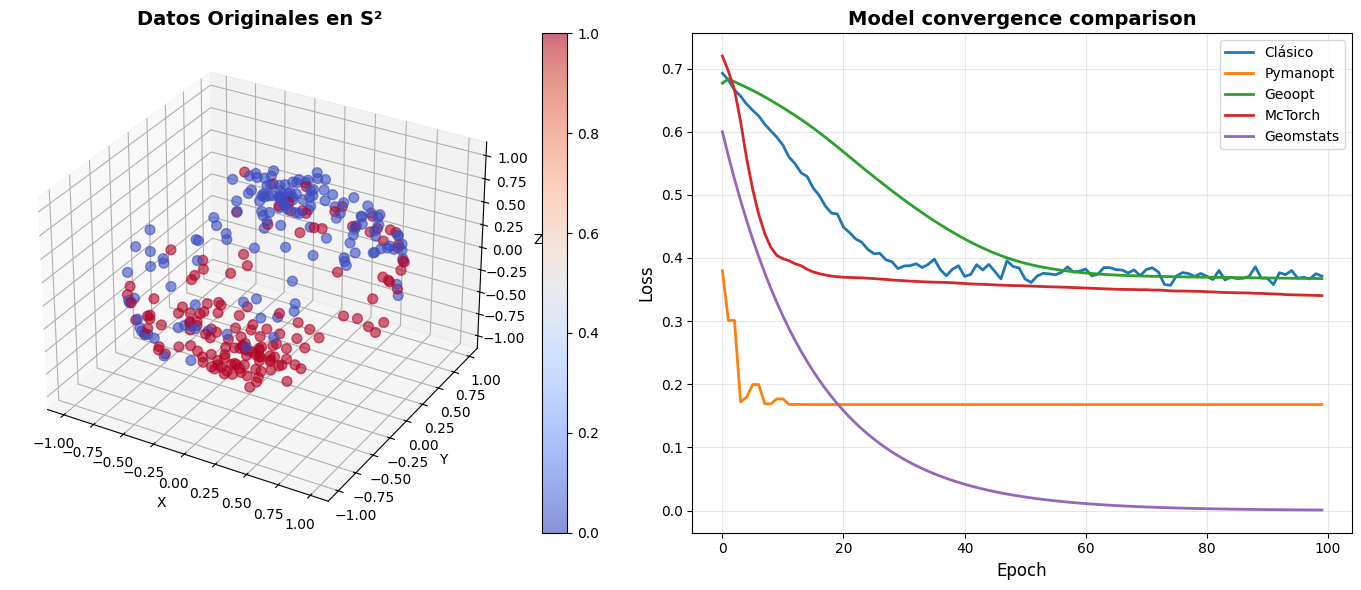

In [36]:
main()

We can see that the results show some improvement using geomtric approaches. However, McTorch and geoopt are very similar to the clasical model, even though the descent is smoother. For that reason, we are going to do another comparison using more complex data to see if the improvement is clearer

## Comparison using more complex data

First, we generate the data

In [ ]:
def generate_sphere_data(n_samples: int = 400, noise: float = 0.2):
    """
    Generates multiple intertwined clusters in the Sphere
    Args:
    - n_samples (int): number of samples to generate
    - noise (float): how much noise to add
    Returns:
    tuple with X and Y (label) data
    """
    np.random.seed(42)
    
    n_per_class = n_samples // 2
    
    # Cluster 0
    clusters_0 = []
    t = np.linspace(0, 2*np.pi, n_per_class//3)
    theta1 = np.pi/6 + 0.1*np.sin(3*t)
    phi1 = t * 1.5
    clusters_0.append((theta1, phi1))
    
    t = np.linspace(0, 4*np.pi, n_per_class//3)
    theta2 = np.pi/2 + 0.15*np.sin(2*t)
    phi2 = t * 0.8
    clusters_0.append((theta2, phi2))
    
    t = np.linspace(0, 3*np.pi, n_per_class//3 + n_per_class % 3)
    theta3 = 5*np.pi/6 + 0.1*np.cos(2*t)
    phi3 = -t * 1.2 + np.pi
    clusters_0.append((theta3, phi3))
    
    # Cluster 1
    clusters_1 = []
    t = np.linspace(0, 2*np.pi, n_per_class//3)
    theta4 = np.pi/6 + 0.1*np.sin(3*t + np.pi)
    phi4 = t * 1.5 + np.pi/2
    clusters_1.append((theta4, phi4))
    
    t = np.linspace(0, 4*np.pi, n_per_class//3)
    theta5 = np.pi/2 + 0.15*np.sin(2*t + np.pi/2)
    phi5 = t * 0.8 + np.pi
    clusters_1.append((theta5, phi5))
    
    t = np.linspace(0, 3*np.pi, n_per_class//3 + n_per_class % 3)
    theta6 = 5*np.pi/6 + 0.1*np.cos(2*t + np.pi)
    phi6 = t * 1.2
    clusters_1.append((theta6, phi6))
    

    theta_0 = np.concatenate([c[0] for c in clusters_0])
    phi_0 = np.concatenate([c[1] for c in clusters_0])
    theta_1 = np.concatenate([c[0] for c in clusters_1])
    phi_1 = np.concatenate([c[1] for c in clusters_1])
    
    theta = np.concatenate([theta_0, theta_1])
    phi = np.concatenate([phi_0, phi_1])
    
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    # Add correlated noise
    X = np.stack([x, y, z], axis=1)
    
    for i in range(len(X)):
        tangent = np.random.randn(3)
        tangent = tangent - np.dot(tangent, X[i]) * X[i]
        if np.linalg.norm(tangent) > 1e-6:
            tangent = tangent / np.linalg.norm(tangent)
            X[i] = X[i] + noise * np.random.randn() * tangent
    
    X = X / np.linalg.norm(X, axis=1, keepdims=True)

    y = np.concatenate([np.zeros(n_per_class), np.ones(n_per_class)])
    
    overlap_noise = 40
    overlap_indices = np.random.choice(n_samples, overlap_noise, replace=False)
    y[overlap_indices] = 1 - y[overlap_indices]
    
    return X.astype(np.float32), y.astype(np.int64)

Now, let's try again

Generating data
300 samples generated

Training classical model
 Final loss: 0.6577

Training with PYMANOPT...
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +2.7890293880972145e-01    2.67532079e-02    
 2           +2.5863114149744237e-01    1.94605739e-02    
 3           +2.5445914102053319e-01    1.11975839e-02    
 4           +2.5442264305730544e-01    1.11259452e-02    
 5           +2.5435080909377716e-01    1.09840982e-02    
 6           +2.5421167645327214e-01    1.07061085e-02    
 7           +2.5395067611819711e-01    1.01727463e-02    
 8           +2.5349113034377296e-01    9.19399462e-03    
 9           +2.5277563804293623e-01    7.55797346e-03    
10           +2.5188636187033392e-01    5.25788522e-03    
11           +2.5114188703572304e-01    2.48274039e-03    
12           +2.5097720548201780e-01    1.10726853e-03    
13           +2.5094428413689407e-01    4.8959533

 Final loss: 0.6157

Training with GEOMSTATS...
Geometric analysis completed

Generating comparison plot


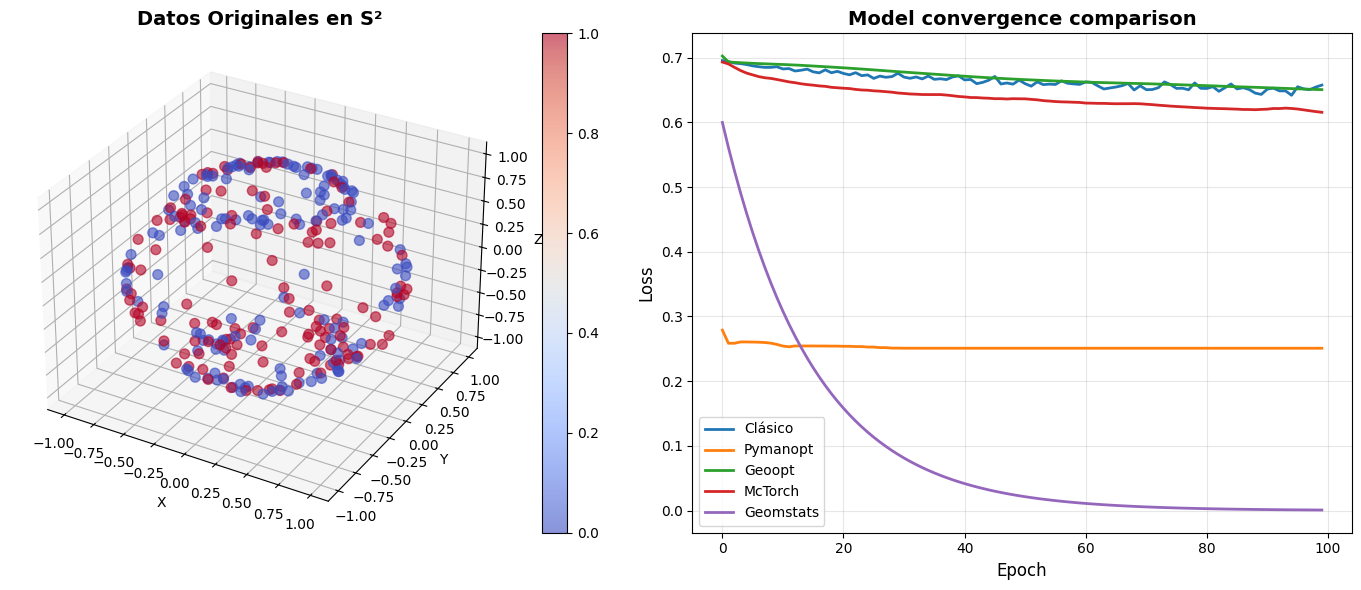

In [38]:
main()

With this examples it looks clear that using a geometry adapted to the data clearly improves the results. McTorch and geoopt are still near the classic, but the descent is far more controlled

## Compare accuracies

Note that we have not optimized the hyperparameters for any of the frameworks. This section is just to compare the accuracy you can expect from a first iteration. With finetuned hyperparemeters the results may vary

First, let's define a function to compute accuracy

In [40]:
def compute_accuracy(model, X, y, model_type='classical'):
    """
    Computes the accuracy of a given model
    """
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    
    with torch.no_grad():
        if model_type == 'pymanopt':
            # For Pymanopt the model is a weight vector
            w = torch.FloatTensor(model).reshape(-1, 1)
            scores = torch.matmul(X_tensor, w)
            predictions = (torch.sigmoid(scores) > 0.5).long().flatten()
        elif model_type == 'geomstats':
            # Geomstats uses geodesic distances to the centers
            center0, center1 = model
            X_np = X
            dist0 = np.linalg.norm(X_np - center0, axis=1)
            dist1 = np.linalg.norm(X_np - center1, axis=1)
            predictions = torch.LongTensor((dist1 < dist0).astype(int))
        else:
            # The rest of the models is done as in "traditional" approaches
            outputs = model(X_tensor)
            _, predictions = torch.max(outputs, 1)
        
        accuracy = (predictions == y_tensor).float().mean().item()
    
    return accuracy * 100

We are also going to define a function to plot the accuracy comparison between the models

In [43]:
def plot_accuracy_comparison(accuracies: dict):
    """
    Generates a bar plot comparing accuracies by model
    """
    
    fig = plt.figure(figsize=(12, 6))
    ax_acc = fig.add_subplot(1, 1, 1)
    
    models = list(accuracies.keys())
    accs = list(accuracies.values())
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'][:len(models)]
    
    bars = ax_acc.bar(models, accs, color=colors, alpha=0.7,
                      edgecolor='black', linewidth=2)
    
    for bar, acc in zip(bars, accs):
        height = bar.get_height()
        ax_acc.text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.1f}%',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax_acc.set_ylabel('Accuracy (%)', fontsize=12)
    ax_acc.set_title('Accuracy by model', fontsize=14, fontweight='bold')
    ax_acc.set_ylim([0, 100])
    ax_acc.grid(axis='y', alpha=0.3)

    ax_acc.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
    ax_acc.legend()
    
    plt.tight_layout()
    
    # Crear carpeta images/ si no existe
    os.makedirs("images", exist_ok=True)
    output_path = "images/accuracy_comparison.png"
    
    # Guardar
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    

Now, lets compare the performances

400 samples generated (highly non-linear pattern)

Training CLASSICAL model...
   Final loss: 0.6435 | Accuracy: 60.0%

Training with PYMANOPT...
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +2.6291146521649728e-01    2.13062890e-02    
 2           +2.4976582751230211e-01    9.52848994e-03    
 3           +2.4818612353685915e-01    4.99830252e-03    
 4           +2.4755154406829732e-01    7.15234896e-04    
 5           +2.4754320890489134e-01    3.35245641e-04    
 6           +2.4754019898575766e-01    4.78180640e-05    
 7           +2.4754013763992902e-01    7.36555326e-06    
 8           +2.4754013632523722e-01    2.51666010e-06    
 9           +2.4754013623733429e-01    3.97317678e-07    
Terminated - min grad norm reached after 9 iterations, 0.00 seconds.

   Optimization completed | Accuracy: 53.5%

Training with GEOOPT...
   Final loss: 0.6528 | Accuracy: 61.5%

Training wi

   Final loss: 0.6052 | Accuracy: 66.3%

Training with GEOMSTATS...
   Geometric analysis completed | Accuracy: 55.5%

Generating accuracy comparison plot...


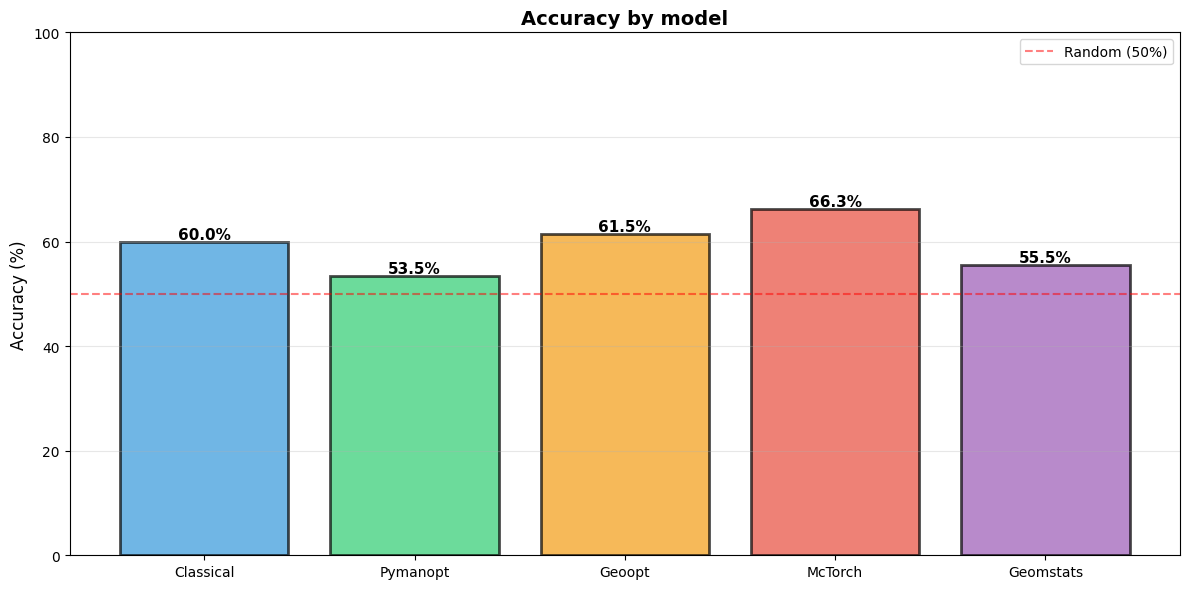

In [44]:
X, y = generate_sphere_data(n_samples=400)
print(f"{len(X)} samples generated (highly non-linear pattern)\n")

results = {}
models = {}
accuracies = {}

# 1. Classical Model
print("Training CLASSICAL model...")
model_classical, losses_classical = train_classical(X, y, epochs=150)
results['Classical'] = losses_classical
models['Classical'] = model_classical
acc_classical = compute_accuracy(model_classical, X, y, 'classical')
accuracies['Classical'] = acc_classical
print(f"   Final loss: {losses_classical[-1]:.4f} | Accuracy: {acc_classical:.1f}%\n")

# 2. Pymanopt
if PYMANOPT_AVAILABLE:
    print("Training with PYMANOPT...")
    try:
        model_pymanopt, losses_pymanopt = train_pymanopt(X, y, epochs=150)
        results['Pymanopt'] = losses_pymanopt
        models['Pymanopt'] = model_pymanopt
        acc_pymanopt = compute_accuracy(model_pymanopt, X, y, 'pymanopt')
        accuracies['Pymanopt'] = acc_pymanopt
        print(f"   Optimization completed | Accuracy: {acc_pymanopt:.1f}%\n")
    except Exception as e:
        print(f"   Error: {e}\n")

# 3. Geoopt
if GEOOPT_AVAILABLE:
    print("Training with GEOOPT...")
    try:
        model_geoopt, losses_geoopt = train_geoopt(X, y, epochs=150)
        results['Geoopt'] = losses_geoopt
        models['Geoopt'] = model_geoopt
        acc_geoopt = compute_accuracy(model_geoopt, X, y, 'geoopt')
        accuracies['Geoopt'] = acc_geoopt
        print(f"   Final loss: {losses_geoopt[-1]:.4f} | Accuracy: {acc_geoopt:.1f}%\n")
    except Exception as e:
        print(f"   Error: {e}\n")

# 4. McTorch
if MCTORCH_AVAILABLE:
    print("Training with MCTORCH...")
    try:
        model_mctorch, losses_mctorch = train_mctorch(X, y, epochs=150)
        results['McTorch'] = losses_mctorch
        models['McTorch'] = model_mctorch
        acc_mctorch = compute_accuracy(model_mctorch, X, y, 'mctorch')
        accuracies['McTorch'] = acc_mctorch
        print(f"   Final loss: {losses_mctorch[-1]:.4f} | Accuracy: {acc_mctorch:.1f}%\n")
    except Exception as e:
        print(f"   Error: {e}\n")

# 5. Geomstats
if GEOMSTATS_AVAILABLE:
    print("Training with GEOMSTATS...")
    try:
        model_geomstats, losses_geomstats = train_geomstats(X, y, epochs=150)
        results['Geomstats'] = losses_geomstats
        models['Geomstats'] = model_geomstats
        acc_geomstats = compute_accuracy(model_geomstats, X, y, 'geomstats')
        accuracies['Geomstats'] = acc_geomstats
        print(f"   Geometric analysis completed | Accuracy: {acc_geomstats:.1f}%\n")
    except Exception as e:
        print(f"   Error: {e}\n")

# Visualization
print("Generating accuracy comparison plot...")
plot_accuracy_comparison(accuracies)


We can see that any of the models are perfect. However, given the loss graphics, the ones with geometry can improve consistently, and the classic may be left untoched. Nevertheless, the models taht take into account geometric information generally perform better